In [58]:
import os
import git
from pathlib import Path

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = False

In [59]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
from reporting import *
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "CSVs")
save_path_with_hull = Path(os.path.join(ROOT_DIR, 'publication', 'paper', 'CSVs', 'final_results_with_hull.pickle'))
main_df = pd.read_pickle(save_path_with_hull)
RERUN = False
np.random.seed(0)
main_df_with_classical = main_df.copy()
main_df = main_df#[(main_df['dataset'] != 'standardTesting') & (main_df['transform'] != 'gabor')]
print(main_df.shape, main_df_with_classical.shape)

(2328, 46) (2328, 46)


In [60]:
main_df['dataset_type'] = main_df.apply((lambda row : row['dataset_type'] if row['dataset'] != 'standardTesting' else 'oclassical'), axis = 1)

## Aggregate Stats

In [61]:
main_df['kstest_stat_overall_best'] = np.minimum.reduce([main_df['kstest_stat_best'], main_df['kstest_stat_gaussian'], main_df['kstest_stat_laplace'], main_df['kstest_stat_t']])
temp = main_df[main_df['beat_all_priors'] == 0].copy()
n = len(main_df)

c1, c0 = main_df['beat_all_priors'].value_counts()
print("% Beats All Other Priors:", c1 / n * 100, ",", c1, "/", n)
trivial_fails, _, _, _, _ = temp['failure_category'].value_counts()
print("Given that OurPrior is Worse, % Trivial Failures:", trivial_fails / n * 100, ",", trivial_fails, "/", n)
print("Of cases where OurPrior is worse, % of Trivial Failures:", trivial_fails / c0 * 100)
temp = temp[temp['failure_category'] != 'trivial_failure']
print("Given that OurPrior is Worse, Maximum difference between OurPrior and Best:", max(np.abs(temp['kstest_stat_overall_best'] - temp['kstest_stat_best'])))

% Beats All Other Priors: 95.83333333333334 , 2231 / 2328
Given that OurPrior is Worse, % Trivial Failures: 3.6941580756013748 , 86 / 2328
Of cases where OurPrior is worse, % of Trivial Failures: 88.65979381443299
Given that OurPrior is Worse, Maximum difference between OurPrior and Best: 0.0035451361585638


In [62]:
main_df['failure_category'].sort_values().value_counts()

failure_category
practically_pass       1759
trivial_failure         280
actually_pass           170
borderline               72
interesting_failure      46
Name: count, dtype: int64

In [63]:
practical, trivial, actual, border, interesting = main_df['failure_category'].sort_values().value_counts()
print("Actually Passing:", (actual) / n)
print("Practically Passing:", (practical) / n)
print("Passing Overall:", (practical + actual) / n)
print("Passing Overall (borderline):", (practical + actual + border) / n)


Actually Passing: 0.07302405498281787
Practically Passing: 0.7555841924398625
Passing Overall: 0.8286082474226805
Passing Overall (borderline): 0.8595360824742269


In [64]:
main_df = main_df[main_df['total_samples'].iloc[:, 0] > 100]
main_df['best_beta'] = (main_df['best_eta'] + 1.5)/main_df['best_r']
main_df = main_df#[(main_df['dataset'] != 'standardTesting')]

In [65]:
name_mapping = {'syntheticMRI3Dfull': 'syntheticMRI3D',
                'syntheticMRI2Daxial': 'syntheticMRI2D (axial)',
                'syntheticMRI2Dsagittal': 'syntheticMRI2D (sagittal)',
                'syntheticMRI2Dcoronal': 'syntheticMRI2D (coronal)',
                'spaceNetfull': 'spaceNet',
                'cocoindoor': 'coco (indoor)',
                'cocooutdoor': 'coco (outdoor)',
                'pastisfull': 'pastis',
                'segmentAnythingfull': 'segmentAnything',
                'agriVisionfull': 'agriVision',
                'standardTestingfull': 'standardTesting'}

main_df['dataset'] = (main_df['dataset'] + main_df['subset']).replace(name_mapping)

In [66]:
main_df['dataset_type'] = main_df['dataset_type'].replace('oclassical', 'natural')
main_df['dataset_type'].value_counts()

dataset_type
natural           1111
remote sensing     964
medical            231
Name: count, dtype: int64

In [67]:
main_df['hull_eta_lower'] = main_df['hull_beta_lower']
main_df["n_pval_0.05"]

0         56952.0
1         74038.0
2        106312.0
3        139218.0
4        212625.0
          ...    
2323      42786.0
2324    1502428.0
2325      90020.0
2326     222910.0
2327     263374.0
Name: n_pval_0.05, Length: 2306, dtype: float64

In [68]:
granularity1 = ['transform', 'dataset_type', 'dataset']
final_cols =  ['median_total_samples', 'kstest_stat_best', 'statistically_pass', 'combined_pass', 'intersect_roi']  #, 'uses_practical_threshold', 'intersect_roi', 'hull_r_lower_ci95', 'hull_r_upper_ci95', 'hull_beta_lower_ci95', 'hull_beta_upper_ci95']
temp = main_df.copy()# & (main_df['transform'] != 'learned')]
temp['orientation'] = temp.apply(
    lambda row: 'fourier' if row['transform'] == 'fourier' 
    else ('learned' if row['transform'] == 'learned' else row['orientation']),
    axis=1
)
temp['practically_pass'] = (temp['failure_category'] == 'practically_pass')
temp['statistically_pass'] = (temp['failure_category'] == 'actually_pass')
temp['borderline'] = (temp['failure_category'] == 'borderline')
temp["interesting_failure"] = (temp['failure_category'] == 'interesting_failure')
temp["trivial_failure"] = (temp['failure_category'] == 'trivial_failure')

summary_df = (temp.groupby(granularity1)[['statistically_pass','practically_pass', "borderline", 'interesting_failure', 'trivial_failure', 'intersect_roi']].mean() * 100).round(1)#.sort_values('dataset')
summary_df["kstest_stat_best"] = temp.groupby(granularity1)['kstest_stat_best'].median(numeric_only=True)
# summary_df["kstest_stat_best_std"] = temp.groupby(granularity1)['kstest_stat_best'].std(numeric_only=True)
# summary_df["kstest_stat_best"] = (summary_df["kstest_stat_best_median"].round(4).astype(str) + " (" + (2*summary_df["kstest_stat_best_std"]).round(4).astype(str) + ")")
summary_df["median_total_samples"] = temp.groupby(granularity1)['total_samples'].median().astype(float).iloc[:,0].apply(lambda x : np.format_float_scientific(x, exp_digits=1, precision=1))
summary_df["combined_pass"] = summary_df['statistically_pass'] + summary_df['practically_pass']

for col in ['hull_r_lower', 'hull_r_upper', 'hull_beta_lower', 'hull_beta_upper']:
    summary_df[f'{col}_ci95'] = temp.groupby(granularity1)[col].apply(lambda x:  [np.round(x, 2) for x in np.percentile(x, [2.5, 97.5])])
summary_df = summary_df[final_cols].round(3) #.reset_index()#.drop('dataset', axis=1)
summary_df

median_total_samples  \
transform dataset_type   dataset                                          
fourier   remote sensing agriVision                              2.6e+6   
                         pastis                                  2.6e+5   
                         spaceNet                                1.8e+6   
gabor     medical        syntheticMRI2D (axial)                  1.8e+8   
                         syntheticMRI2D (coronal)                1.4e+8   
                         syntheticMRI2D (sagittal)               9.7e+7   
          natural        coco (indoor)                           6.6e+7   
                         coco (outdoor)                          6.6e+7   
                         segmentAnything                         2.6e+8   
                         standardTesting                         2.4e+6   
          remote sensing agriVision                              2.6e+8   
                         pastis                                  1.6e+7   
                         spaceNet                                1.6e+8   
learned   natural        coco (indoor)                            2.e+8   
                         coco (outdoor)                           2.e+8   
                         segmentAnything                         7.9e+8   
                         standardTesting                         7.1e+6   
          remote sensing agriVision                              7.9e+8   
                         pastis                                  4.9e+7   
                         spaceNet                                4.8e+8   
wavelet   medical        syntheticMRI2D (axial)                  4.2e+6   
                         syntheticMRI2D (coronal)                3.7e+6   
                         syntheticMRI2D (sagittal)               2.4e+6   
                         syntheticMRI3D                          1.6e+6   
          natural        coco (indoor)                           2.6e+5   
                         coco (outdoor)                          3.9e+5   
                         segmentAnything                         1.8e+6   
                         standardTesting                         9.2e+3   
          remote sensing agriVision                              1.7e+6   
                         pastis                                  1.5e+5   
                         spaceNet                                1.6e+6   

                                                    kstest_stat_best  \
transform dataset_type   dataset                                       
fourier   remote sensing agriVision                            0.005   
                         pastis                                0.002   
                         spaceNet                              0.005   
gabor     medical        syntheticMRI2D (axial)                0.005   
                         syntheticMRI2D (coronal)              0.003   
                         syntheticMRI2D (sagittal)             0.004   
          natural        coco (indoor)                         0.006   
                         coco (outdoor)                        0.004   
                         segmentAnything                       0.003   
                         standardTesting                       0.008   
          remote sensing agriVision                            0.003   
                         pastis                                0.001   
                         spaceNet                              0.007   
learned   natural        coco (indoor)                         0.009   
                         coco (outdoor)                        0.010   
                         segmentAnything                       0.005   
                         standardTesting                       0.014   
          remote sensing agriVision                            0.005   
                         pastis                                0.004   
                         spaceNet                              

In [69]:
granularity2 = ['transform', 'dataset_type']
temp = main_df.copy()# & (main_df['transform'] != 'learned')]
temp['orientation'] = temp.apply(
    lambda row: 'fourier' if row['transform'] == 'fourier' 
    else ('learned' if row['transform'] == 'learned' else row['orientation']),
    axis=1
)
temp['practically_pass'] = (temp['failure_category'] == 'practically_pass')
temp['statistically_pass'] = (temp['failure_category'] == 'actually_pass')
temp['borderline'] = (temp['failure_category'] == 'borderline')
temp["interesting_failure"] = (temp['failure_category'] == 'interesting_failure')
temp["trivial_failure"] = (temp['failure_category'] == 'trivial_failure')
summary_df2 = (temp.groupby(granularity2)[['statistically_pass','practically_pass', "borderline", 'interesting_failure', 'trivial_failure', 'intersect_roi']].mean() * 100).round(1)#.sort_values('dataset')
summary_df2["kstest_stat_best"] = temp.groupby(granularity2)['kstest_stat_best'].median(numeric_only=True)
summary_df2["kstest_stat_best_std"] = temp.groupby(granularity2)['kstest_stat_best'].std(numeric_only=True)
summary_df2["median_total_samples"] = temp.groupby(granularity2)['total_samples'].median().astype(float).iloc[:,0].apply(lambda x : np.format_float_scientific(x, 1))
summary_df2["combined_pass"] = summary_df2['statistically_pass'] + summary_df2['practically_pass']
for col in ['hull_r_lower', 'hull_r_upper', 'hull_beta_lower', 'hull_beta_upper']:
    summary_df2[f'{col}_ci95'] = temp.groupby(granularity2)[col].apply(lambda x:  [np.round(x, 1) for x in np.percentile(x, [2.5, 97.5])])


summary_df2 = summary_df2[final_cols].round(3) #.reset_index()#.drop('dataset', axis=1)
summary_df2 = summary_df2.assign(dataset='z_aggregate').reset_index().set_index(granularity1)
summary_df_final = pd.concat([summary_df, summary_df2]).reset_index()

summary_df_final['transform'] = pd.Categorical(summary_df_final['transform'], categories=['fourier', 'gabor', 'wavelet', 'learned'], ordered=True)
summary_df_final = summary_df_final.sort_values(['transform', 'dataset_type', 'dataset'])
summary_df_final.to_csv(os.path.join(plots_path, 'results_table.csv'))

In [70]:
summary_df_final

,transform,dataset_type,dataset,median_total_samples,kstest_stat_best,statistically_pass,combined_pass,intersect_roi
0,fourier,remote sensing,agriVision,2.6e+6,0.005,2.3,95.5,68.2
1,fourier,remote sensing,pastis,2.6e+5,0.002,90.9,100.0,100.0
2,fourier,remote sensing,spaceNet,1.8e+6,0.005,0.0,100.0,46.9
31,fourier,remote sensing,z_aggregate,5.5e+05,0.003,34.2,98.4,74.2
3,gabor,medical,syntheticMRI2D (axial),1.8e+8,0.005,0.0,95.2,59.5
4,gabor,medical,syntheticMRI2D (coronal),1.4e+8,0.003,0.0,95.2,88.1
5,gabor,medical,syntheticMRI2D (sagittal),9.7e+7,0.004,0.0,97.6,76.2
32,gabor,medical,z_aggregate,1.4e+08,0.004,0.0,96.0,74.6
6,gabor,natural,coco (indoor),6.6e+7,0.006,0.0,97.0,10.7
7,gabor,natural,coco (outdoor),6.6e+7,0.004,0.0,95.8,0.0


In [71]:
print("Median Total Samples Overall:", temp[['total_samples']].median().iloc[0])
print("Median KS statistic:", temp[['kstest_stat_best']].median().iloc[0])
temp[['statistically_pass', 'practically_pass', 'intersect_roi']].mean()

Median Total Samples Overall: 65536000.0
Median KS statistic: 0.0047323401710862995


statistically_pass    0.073721
practically_pass      0.762793
intersect_roi         0.428881
dtype: float64

In [84]:
temp[['total_samples']].median().iloc[0] // 1e7

6.0

In [72]:
temp[['statistically_pass', 'practically_pass', 'intersect_roi', 'hull_area', 'total_samples']].mean(), main_df[['total_samples']].median()


(statistically_pass    7.372073e-02
 practically_pass      7.627927e-01
 intersect_roi         4.288812e-01
 hull_area             7.812335e+00
 total_samples         1.428310e+08
 total_samples         1.428310e+08
 dtype: float64,
 total_samples    65536000.0
 total_samples    65536000.0
 dtype: float64)

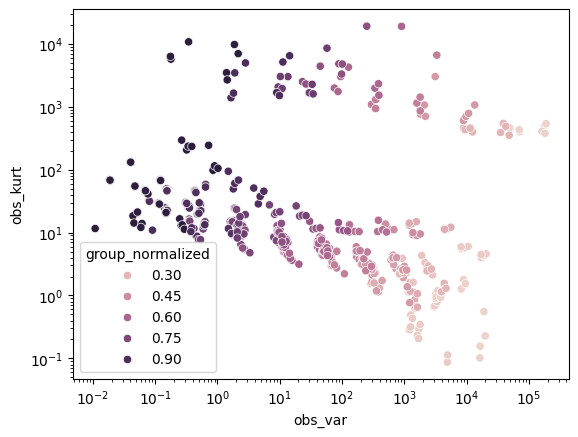

In [73]:
main_df['group_normalized'] = main_df.groupby(['dataset', 'channel', 'orientation'])['group'].transform(lambda x: x / x.max())
main_df['var_normalized'] = main_df.groupby(['dataset', 'channel', 'orientation'])['obs_var'].transform(lambda x: x / x.max())
main_df['kurt_normalized'] = main_df.groupby(['dataset', 'channel', 'orientation'])['obs_kurt'].transform(lambda x: x / x.max())
sns.scatterplot(data=main_df[main_df['transform'] != 'learned'], x='obs_var', y='obs_kurt', hue='group_normalized')
plt.xscale('log')
plt.yscale('log')


In [74]:
[stats.kstwo(n=10**i).isf(0.05) for i in range(3, 10)]

[0.042776500461245,
 0.013564202793681023,
 0.004293014618329405,
 0.0013579318555276864,
 0.0004294518283725128,
 0.00013580819714844155,
 4.294668320280901e-05]

In [75]:
main_df['n_pval_0.05']

0         56952.0
1         74038.0
2        106312.0
3        139218.0
4        212625.0
          ...    
2323      42786.0
2324    1502428.0
2325      90020.0
2326     222910.0
2327     263374.0
Name: n_pval_0.05, Length: 2306, dtype: float64

<Axes: >

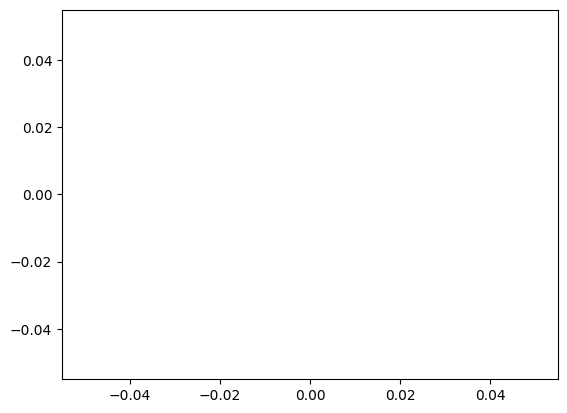

In [76]:
sns.histplot()